# Selected calculation for 
## Binary Black Hole merger in $f(R)$ theory
### Zhoujian Cao ,  Pablo Galaviz,  and Li-Fang Li3 
### DOI: https://doi.org/10.1103/PhysRevD.87.104029
### ArXiv: https://arxiv.org/abs/1608.07816

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.integrate import ode
%matplotlib inline 

# C. Results 
## 1. Test problem 

Numerical solution of 

(41)$$ \psi_1''+ \pi \psi_1(\phi')+2\pi V(r)\frac{\psi_1^5}{r^4} =0,$$
(42)$$ \psi_1(0) = 0,$$ 
(43)$$ \psi_1'(r_\mathrm{max} ) = 1.$$ 

## Case I 

We use the following scalar field and potential (**note that the paper has a missing factor before $\phi_0$**):

$$ \phi(r)=\left( \frac{a_2^2}{a_2^2+1}\right)\phi_0 \tanh[(r-r_0])/\sigma ,$$
$$ V(r)=0$$

We will reduce (41) to a first order form introducing $y_0=\psi_1$ and $y_1:=\psi_1'$ 

therefore. In first order form: 


(41-a')$$ y_0'=y_1,$$
(41-b')$$ y_1'= - \pi y_0(\phi'),$$
(42')$$ y_0(0) = 0,$$ 
(43')$$ y_1(r_\mathrm{max} ) = 1.$$ 

in code we refer to the right hand side of this system as `rhs_TI`

In [2]:
r0=120.
sigma=8.
phi0=1/40.
a2=1

def rhs_TI(t, y):
    dphi=(a2**2/(a2**2+1))*phi0*(1-np.tanh((t-r0)/sigma)**2)/sigma
    return [y[1], -np.pi*y[0]*dphi**2]

def integrate_rhs(_x,_ode_solver,_rf,_dr=0.1,save_data=False):    
    y0, r0 = [0.0, _x], 0        
    _ode_solver.set_initial_value(y0, r0)
    data_list=list()
    while _ode_solver.successful() and _ode_solver.t < _rf:
        if save_data and _ode_solver.t > 0:
            data_list.append({'r':_ode_solver.t, 'u' : _ode_solver.y[0]/_ode_solver.t-1, 'dpsi' : _ode_solver.y[1]})
        _ode_solver.integrate(_ode_solver.t+_dr)
    if save_data:
        return data_list
    return _ode_solver.y, _ode_solver.t
    
def sm_ode(rhs):
    '''
    Solves the equation using shotting method 
    '''
    #set ode integrator 
    ode_solver = ode(rhs).set_integrator('dopri5', rtol=1e-6)
    
    # final integration 
    rf = 2000
    
    #shotting method search for solution of ode_solver.y[1] at r=rf 
    #gives an initial interval for ode_solver.y[1] at r=r0
    #then try to find ode_solver.y[1](r0) shuch that ode_solver.y[1](tf) == target
    x_i=1
    x_f=1.2
    
    #target asymptotic value  
    target=1
    
    #minum error for solution 
    tolerance=0.0001
    
    #store the result for 3 points [x_i, x, x_f]
    result=[0,0,0]
    
    
    data_list=list()
    while(True):
        
        #make a random cut of the interval [x_i,x_f]
        partition=np.random.rand()*(x_f-x_i)+x_i
        
        for x,i in zip([x_i,partition,x_f],[0,1,2]):
            #integrate for each initial value of y[1]
            y,r = integrate_rhs(x,ode_solver,rf, _dr=1)        
            result[i]=np.abs(y[1])
            
        #test each solution to see if we have a good enough solution 
        if np.abs(result[0] - target) < tolerance:
            #x_i is a good solution 
            #solve again but this time save the solution 
            data_list=integrate_rhs(x_i,ode_solver,rf,save_data=True)
            print('solution', x_i)
            break
        elif np.abs(result[1] - target) < tolerance:
            #partition is a good solution 
            #solve again but this time save the solution 
            data_list=integrate_rhs(partition,ode_solver,rf,save_data=True)
            print('solution', partition)
            break
        elif np.abs(result[2] - target) < tolerance:
            #x_f is a good solution 
            #solve again but this time save the solution 
            data_list=integrate_rhs(x_f,ode_solver,rf,save_data=True)
            print('solution', x_f)
            break 

        #find the location of the solution between [x_i,partition] and [partition,xf]
        #reduce the interval
        if result[0] < target and target <= result[1]:
            x_f=partition
        elif result[1] < target and target <= result[2]:
            x_i=partition
        else:
            print('Solution out of interval',result)
            break

        print('Current error',[ np.abs(x-target) for x in result])
    return data_list
 

In [3]:
   
df_TestI=pd.DataFrame(sm_ode(rhs_TI))

Current error [0.0098155115005170712, 0.060209176735497527, 0.18822138619938]
Current error [0.0098155115005170712, 0.0067409451287949729, 0.060209176735497527]
Current error [0.0098155115005170712, 0.0085198446362633184, 0.0067409451287949729]
Current error [0.0085198446362633184, 0.0041627001009719722, 0.0067409451287949729]
Current error [0.0041627001009719722, 0.00035610539563557531, 0.0067409451287949729]
Current error [0.0041627001009719722, 0.00075009540659221052, 0.00035610539563557531]
Current error [0.00075009540659221052, 0.00030464443413635856, 0.00035610539563557531]
Current error [0.00075009540659221052, 0.00020505316866792356, 0.00030464443413635856]
Current error [0.00075009540659221052, 0.00018608054943225483, 0.00020505316866792356]
solution 1.0099859077443418


### Here we compare case I with the original data generated with mathematica 

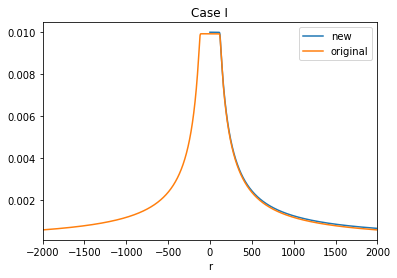

In [4]:
#read original data 
df_original_TI = pd.read_table('original_testI_u.tsv.gz',compression='gzip',header=0,names=['r','na','u'])
ax=df_TestI.set_index('r')['u'].plot(title='Case I')
df_original_TI.set_index('r')['u'].plot(ax=ax)
ax.legend(['new','original'])


## Case II 

We use the following scalar field and potential (**note that the paper has a missing factor before $\phi_0$**):

$$ \phi(r)=\left( \frac{a_2^2}{a_2^2+1}\right)\phi_0 \mathrm{e}^{-\frac{(r-r_0)^2}{\sigma}} ,$$
$$ V(r)= \frac{1}{32\pi a_2}\left( 1- \mathrm{e}^{4\sqrt{\pi/3} \phi} \right)^2 \mathrm{e}^{-8\sqrt{\pi/3} \phi}$$

We will reduce (41) to a first order form introducing $y_0=\psi_1$ and $y_1:=\psi_1'$ 

therefore. In first order form: 


(41-a')$$ y_0'=y_1,$$
(41-b')$$ y_1'= - \pi y_0(\phi')-2\pi V(r)\frac{\psi_1^5}{r^4+\epsilon},$$
(42')$$ y_0(0) = 0,$$ 
(43')$$ y_1(r_\mathrm{max} ) = 1.$$ 

where $\epsilon=10^{-12}$ is introduced to avoid singular values in the solution 

in code we refer to the right hand side of this system as `rhs_TI`

In [5]:

def rhs_TII(t, y):
    phi=(a2**2/(a2**2+1))*phi0*np.exp( -(t-r0)**2/sigma )
    dphi=-2*phi*(t-r0)/sigma
    V=(1-np.exp(4*np.sqrt(np.pi/3)*phi))**2*np.exp(-8*np.sqrt(np.pi/3.)*phi)/(32.*np.pi*a2)
    #cure the singulatiry with the term t**4+1e-12 instead of t**4
    return [y[1], -np.pi*y[0]*dphi**2-2*np.pi*V*y[0]**5/(t**4+1e-12)]
    
df_TestII=pd.DataFrame(sm_ode(rhs_TII))

Current error [0.092614302230255019, 0.016870927528310986, 0.0035538167643958118]
Current error [0.016870927528310986, 0.014684447365205688, 0.0035538167643958118]
Current error [0.014684447365205688, 0.0015961209162043133, 0.0035538167643958118]
Current error [0.0015961209162043133, 0.00036770417244202935, 0.0035538167643958118]
Current error [0.00036770417244202935, 0.0031272703759723797, 0.0035538167643958118]
Current error [0.00036770417244202935, 0.0019248107160847461, 0.0031272703759723797]
solution 1.1882959522961807


### Here we compare case II with the original data generated with mathematica 

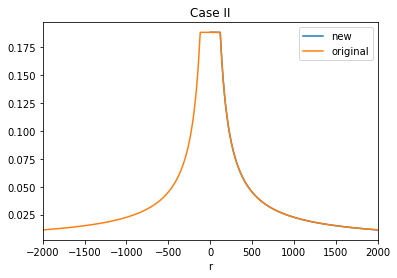

In [6]:
#read original data 
df_original_TII = pd.read_table('original_testII_u.tsv.gz',compression='gzip',header=0,names=['r','na','u'])
ax=df_TestII.set_index('r')['u'].plot(title='Case II')
df_original_TII.set_index('r')['u'].plot(ax=ax)
ax.legend(['new','original'])


## 1. Test problem correction 

There is a typo in the paper's equation (41). The intended test is missing a $1/r$ factor in the second term. 
The overall restuls are not changed by this typo. We intended to test:

(41'')$$ \psi_1''+ \frac{\pi}{r} \psi_1(\phi')+2\pi V(r)\frac{\psi_1^5}{r^4} =0,$$
(42'')$$ \psi_1(0) = 0,$$ 
(43'')$$ \psi_1'(r_\mathrm{max} ) = 1.$$ 

in the code we will add a term $\epsilon=10^{-12}$ to the factors $1/r$ and $1/r^4$ to avoid singular values  

# Case I (correction) 

In [7]:
def rhs_TIa(t, y):
    dphi=(a2**2/(a2**2+1))*phi0*(1-np.tanh((t-r0)/sigma)**2)/sigma
    return [y[1], -np.pi*y[0]*dphi**2/(t+1e-12)]

df_TestIa = pd.DataFrame(sm_ode(rhs_TIa))

solution 1


### Here we compare with the original solution

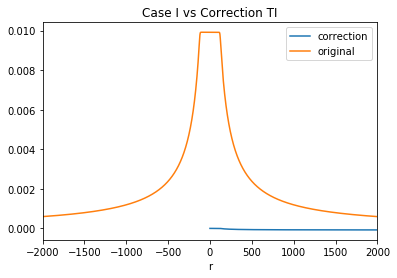

In [8]:

ax=df_TestIa.set_index('r')['u'].plot(title='Case I vs Correction TI')
df_original_TI.set_index('r')['u'].plot(ax=ax)
ax.legend(['correction','original'])

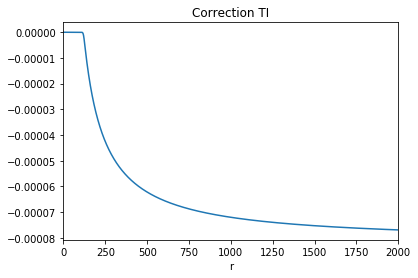

In [9]:
df_TestIa.set_index('r')['u'].plot(title='Correction TI')

# Case II (correction) 

In [10]:
def rhs_TIIa(t, y):
    phi=(a2**2/(a2**2+1))*phi0*np.exp( -(t-r0)**2/sigma )
    dphi=-2*phi*(t-r0)/sigma
    V=(1-np.exp(4*np.sqrt(np.pi/3)*phi))**2*np.exp(-8*np.sqrt(np.pi/3.)*phi)/(32.*np.pi*a2)
    #cure the singulatiry with the term t**4+1e-12 instead of t**4
    return [y[1], -np.pi*y[0]*dphi**2/(t+1e-12)-2*np.pi*V*y[0]**5/(t**4+1e-12)]
    
df_TestIIa=pd.DataFrame(sm_ode(rhs_TIIa))

Current error [0.066839216384930178, 0.029602979617195935, 0.034354453858439493]
Current error [0.066839216384930178, 0.045918296603964071, 0.029602979617195935]
Current error [0.045918296603964071, 0.012273991613970359, 0.029602979617195935]
Current error [0.012273991613970359, 0.0053245892056756894, 0.029602979617195935]
Current error [0.0053245892056756894, 0.011127211111162216, 0.029602979617195935]
Current error [0.0053245892056756894, 0.0069621993236319568, 0.011127211111162216]
Current error [0.0053245892056756894, 0.0035786289253585402, 0.0069621993236319568]
Current error [0.0053245892056756894, 0.0027050534830613815, 0.0035786289253585402]
Current error [0.0027050534830613815, 0.0010081921471944977, 0.0035786289253585402]
Current error [0.0010081921471944977, 0.0027626631738451035, 0.0035786289253585402]
Current error [0.0010081921471944977, 0.00030971487370945461, 0.0027626631738451035]
Current error [0.0010081921471944977, 0.00071928667270748647, 0.00030971487370945461]
Cur

### Here we compare with the original solution¶

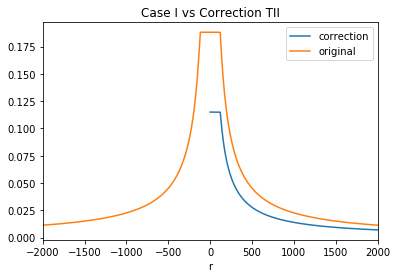

In [11]:
#read original data 
ax=df_TestIIa.set_index('r')['u'].plot(title='Case I vs Correction TII')
df_original_TII.set_index('r')['u'].plot(ax=ax)
ax.legend(['correction','original'])